# 语义分割(Semantic Segmentation)学习笔记

## 一.了解语义分割

### 1.语义分割干了啥？

之前我们已经介绍过了图像识别的三大任务——图像分类、图像分割、图像定位。

如果说图像分类是对一整张图片进行**识别(确定：类别+位置信息(可选))**、图像定位是对图像中部分或者多个图像部分进行识别，那么图像分割就是对图像的**像素点**进行分类。

### 2.语义分割可以干啥？

包括自动驾驶汽车、人机交互、虚拟现实等，当然还有医疗领域的影像处理——eg：查找坏死部位。

### 3.语义分割的实现原理？

语义分割归结来说还是classification问题的衍生：只不过是完成对**pixel（像素）**的分类。

图像分类我们是基于回归问题衍生而来，那么我们就用图像分类的原理来完成对语义分割原理的解释：

- 首先，明白神经网络要对输入图像完成什么样的一个映射？
  
  图像分类问题完成的是：输入(二维或者三维)矩阵 -> scaler(单个数值)的映射。
  语义分割问题完成的是：输入矩阵 -> 输出矩阵的映射。
----  
Tips:

这里可能就有小伙伴会问了：为什么没有label啊？目标检测(Object Detection)都是把类别标注(annotate)出来了呀。
  
这也是我刚刚接触语义分割的一大误区，语义分割实际上是不用标注出类别名称的，可以这样讲：目标检测我们在bbox左上方写出class实际上只是为了方便观察，真正起到划分作用的是annotation里面的label标签的数据——也就是目标检测映射输出的**列向量(包含bbox的各类信息)**。
  
因此，就我个人认为，语义分割就是人类识别图像的另一个任务：将拿到的图片或者看到的东西和自己**脑海中的图片**比对，学习(train)认识这张图片中内容的时候，就是在不断比对图片，并刷新(update)自己的认识(parameter),最后得到一个固定的认识(model)。

----
- 其次，明白如何实现这个映射？
  
  明白了完成什么亚子的映射我们就完成了大部分，但是要如何去实现呢？图像分类通过CNN降低了图像分辨率、提高了**语义信息(所谓语义信息，在这里的话，可以理解为，每一个像素代表哪一类别)**，而我们语义分割的目的就是对语义信息进行分割，那么显而易见：CNN的convlayer(卷积层)最后一层输出的语义信息最多，那么我们就从这里下手。

  既然这里语义信息最多，考虑到输出的是一张图片tensor，那么我们就得对我们convlayer得到的特征图进行降维(这里的得到的feature map维度一般都很大并且尺寸小)、增加分辨率。

- 最后，了解采用什么样子得方法去实现降维、增加分辨率的操作？
  
  upsample(上采样)或是反卷积的操作，接下来我们会简单介绍一下语义分割与图像分类不同的地方。

## 二.加密器和解码器、上采样与反卷积、成本函数

In [2]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.nn import *
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

### 1.Encoder+Decoder

Encoder、Decoder翻译过来就是加密器和解码器的意思。

如果我们使用卷积操作对原始图片进行处理，会发向图片会变成我们看不懂的东西，因为这个时候图像的信息维度增加，但是尺寸减小，为Encode——加密过程。

那么如果我们采用**某种方式**，反向而行之，图像尺寸变大，信息维度减少，语义信息变少，变成我们看得懂的图片，这个过程就是decoder过程。

常见的方式就有反卷积和上采样。

torch.Size([3, 256, 256])


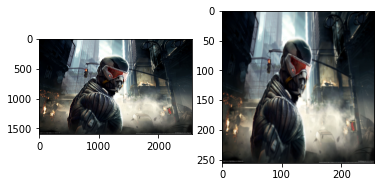

In [5]:
# 先定义两个transformer，一个把rgb图像转成tensor另一个把tensor转成rgb图。
file=Image.open('./imgs/img1.jpg')
plt.subplot(1,2,1)
plt.imshow(file)
transformer=transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])
transformer1=transforms.Compose([
    transforms.ToPILImage()
])
img_tensor=transformer(file)
print(img_tensor.shape)
plt.subplot(1,2,2)
plt.imshow(transformer1(img_tensor))


torch.Size([1, 64, 128, 128])
torch.Size([1, 64, 256, 256])
torch.Size([1, 3, 256, 256])


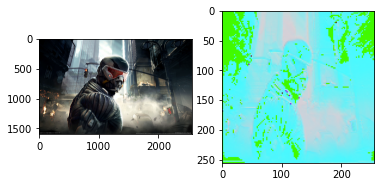

In [11]:
# 简单设计一个encoder+decoder的过程
class TestModel(Module):
    def __init__(self):
        super(TestModel,self).__init__()
        self.encoder=Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=2,padding=1)
        self.decoder=Upsample(scale_factor=2)   # 先了解Upsample可以提高size就行，scale_factor是尺度因子，就是尺寸提高多少倍数
        self.decoder1=Conv2d(in_channels=64,out_channels=3,kernel_size=1)        
    def forward(self,x):
        x=self.encoder(x)
        print(x.shape)
        x=self.decoder(x)
        print(x.shape)
        x=self.decoder1(x)
        print(x.shape)
        
        return x
model=TestModel()
file=Image.open('./imgs/img1.jpg')
plt.subplot(1,2,1)
plt.imshow(file)
inputs=transformer(file).reshape(1,3,256,256)
outputs=model(inputs).reshape((3,256,256))
out_file=transformer1(outputs)
plt.subplot(1,2,2)
plt.imshow(out_file)


我们看到简简单单的upsample其实可以完成基本的encoder和decoder过程，而且我们发现原图像中深色部分与浅色部分的差异比较大，这是为什么呢？我们来了解一下上采样。

### 2.上采样和反卷积

严格意义上来讲，上采样包含反卷积操作，因为上采样可以理解为增加图片尺寸、减少语义信息的操作，反卷积其实也有这个作用，故也可以称作上采样。

但是我们这里讨论的是pytorch中的上采样与反卷积操作。

#### (1)上采样(Upsample)

In [12]:
help(Upsample)

Help on class Upsample in module torch.nn.modules.upsampling:

class Upsample(torch.nn.modules.module.Module)
 |  Upsample(size: Union[int, Tuple[int, ...], NoneType] = None, scale_factor: Union[float, Tuple[float, ...], NoneType] = None, mode: str = 'nearest', align_corners: Union[bool, NoneType] = None) -> None
 |  
 |  Upsamples a given multi-channel 1D (temporal), 2D (spatial) or 3D (volumetric) data.
 |  
 |  The input data is assumed to be of the form
 |  `minibatch x channels x [optional depth] x [optional height] x width`.
 |  Hence, for spatial inputs, we expect a 4D Tensor and for volumetric inputs, we expect a 5D Tensor.
 |  
 |  The algorithms available for upsampling are nearest neighbor and linear,
 |  bilinear, bicubic and trilinear for 3D, 4D and 5D input Tensor,
 |  respectively.
 |  
 |  One can either give a :attr:`scale_factor` or the target output :attr:`size` to
 |  calculate the output size. (You cannot give both, as it is ambiguous)
 |  
 |  Args:
 |      size (

先来看看用法吧：

1.输入要求：要求为大小为(单个训练batch大小，通道数，[可选深度、可选高度]、宽度)的tensor。
  
        The input data is assumed to be of the form
        `minibatch x channels x [optional depth] x [optional height] x width`.
2.常用的输入参数：
  - size:是一个整型数据或者是整型元组，是指定输出的tensor的空间大小。
  - scale_factor:是一个浮点型或者是浮点型的元组，可以理解为：上采样扩大的倍数。
  - mode:指定所使用的上采样方法——默认为：“nearest”，还有'linear'、'bilinear'、'bicubic'、'trilinear'总共五种方法。

说了这么多，我们再来了解一下具体upsample是怎么用的？网上没有比较准确的对这几种方法的解释，我们就一起来探究一下nearest和bilinear，因为这两种经常用于常见的图像处理。

In [23]:
input_tensor=torch.randint(0,9,(1,1,2,2)).float()
# 可以理解为通道数为1，batchsize为1，尺寸为2*2的张量
print(input_tensor,input_tensor.dtype)

tensor([[[[6., 1.],
          [3., 1.]]]]) torch.float32


接下来我们都使用scale_factor来进行上采样——放大两倍

##### (1)'nearest

In [24]:
outputs1=Upsample(scale_factor=2,mode='nearest')(input_tensor)
print(outputs1)
print(outputs1.shape)

tensor([[[[6., 6., 1., 1.],
          [6., 6., 1., 1.],
          [3., 3., 1., 1.],
          [3., 3., 1., 1.]]]])
torch.Size([1, 1, 4, 4])


好像只是简单的复制哈，我们来夸张一点呢？

In [25]:
outputs1=Upsample(scale_factor=128,mode='nearest')(input_tensor)
print(outputs1)
print(outputs1.shape)

tensor([[[[6., 6., 6.,  ..., 1., 1., 1.],
          [6., 6., 6.,  ..., 1., 1., 1.],
          [6., 6., 6.,  ..., 1., 1., 1.],
          ...,
          [3., 3., 3.,  ..., 1., 1., 1.],
          [3., 3., 3.,  ..., 1., 1., 1.],
          [3., 3., 3.,  ..., 1., 1., 1.]]]])
torch.Size([1, 1, 256, 256])


基本上可以说明nearest方法就是顾名思义：以每一个元素为中心，在最近的位置进行一个**插值**，辐射的范围就是scale_factor。

##### (2)'bilinear

在了解bilinear之前我们可以了解一下**线性插值**，因为bilinear以及它的3d形式linear(linear只能用3维tensor)都是运用了线性插值的思想。

对于linear运用的是平面中的线性插值，也就是2d——现在的问题就是已知多个离散点，通过线性插值求出多个未知点，假如我给定你两个点(x0,y0)、(x1,y1)，要你在之前**线性插入**一个点：

$$
\\
k=\frac{y_1-y_0}{x_1-x_0}
\\
y=\frac{y_1-y_0}{x_1-x_0}(x-x_0)+y_0
$$

In [40]:
input_tensor1=torch.randint(0,9,(1,2,2)).float()
print(input_tensor1,input_tensor1.shape)
outputs2=Upsample(scale_factor=2,mode='linear')(input_tensor1)
print(outputs2,outputs2.shape)

tensor([[[1., 8.],
         [2., 7.]]]) torch.Size([1, 2, 2])
tensor([[[1.0000, 2.7500, 6.2500, 8.0000],
         [2.0000, 3.2500, 5.7500, 7.0000]]]) torch.Size([1, 2, 4])


对于bilinear就是比linear多了一个维度：

In [41]:
input_tensor1=torch.randint(0,9,(1,1,2,2)).float()
print(input_tensor1,input_tensor1.shape)
outputs2=Upsample(scale_factor=2,mode='bilinear')(input_tensor1)
print(outputs2,outputs2.shape)

tensor([[[[0., 7.],
          [0., 2.]]]]) torch.Size([1, 1, 2, 2])
tensor([[[[0.0000, 1.7500, 5.2500, 7.0000],
          [0.0000, 1.4375, 4.3125, 5.7500],
          [0.0000, 0.8125, 2.4375, 3.2500],
          [0.0000, 0.5000, 1.5000, 2.0000]]]]) torch.Size([1, 1, 4, 4])


我们再来看看这两种形式表现在图像上是怎么样的？


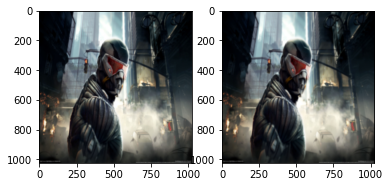

In [49]:
file=Image.open('./imgs/img1.jpg')
plt.imshow(file)
inputs=transformer(file).reshape(1,3,256,256)
out_f1=transformer1(Upsample(scale_factor=4,mode='nearest')(inputs).reshape((3,1024,1024)))
out_f2=transformer1(Upsample(scale_factor=4,mode='bilinear')(inputs).reshape((3,1024,1024)))
plt.subplot(1,2,1)
plt.imshow(out_f1)
plt.subplot(1,2,2)
plt.imshow(out_f2)

#### (2)反卷积(ConvTranspose)

In [50]:
help(ConvTranspose2d)

Help on class ConvTranspose2d in module torch.nn.modules.conv:

class ConvTranspose2d(_ConvTransposeNd)
 |  ConvTranspose2d(in_channels: int, out_channels: int, kernel_size: Union[int, Tuple[int, int]], stride: Union[int, Tuple[int, int]] = 1, padding: Union[int, Tuple[int, int]] = 0, output_padding: Union[int, Tuple[int, int]] = 0, groups: int = 1, bias: bool = True, dilation: int = 1, padding_mode: str = 'zeros')
 |  
 |  Applies a 2D transposed convolution operator over an input image
 |  composed of several input planes.
 |  
 |  This module can be seen as the gradient of Conv2d with respect to its input.
 |  It is also known as a fractionally-strided convolution or
 |  a deconvolution (although it is not an actual deconvolution operation).
 |  
 |  This module supports :ref:`TensorFloat32<tf32_on_ampere>`.
 |  
 |  * :attr:`stride` controls the stride for the cross-correlation.
 |  
 |  * :attr:`padding` controls the amount of implicit zero-paddings on both
 |    sides for ``dilat

可以看到反卷积操作其函数和用法和我们的普通卷积毫无区别，所以我们侧重讲一下反卷积的作用以及如何计算输出大小的。

我们先来看一下卷积操作，这里为了方便讨论我们就以正方形的卷积为讨论对象，矩形也是同理，只不过是维度不同而已。

假设输入为i，输出为o，步长为s，padding为p，卷积核大小为k，那么有
$$
o=[\frac{i-k+2p}{s}]+1([x]为向下取整)
$$


然后，反卷积的话，其实操作过程跟我们的卷积是一样的运用了滑动窗口的方法，并且反卷积嘛。。。就是卷积操作反过来，那么是不是可以猜想同等条件下(参数相同、权重相同)的反卷积和卷积操作的输入输出大小**交叉相等**。

假设卷积操作参数(i,s,p,k)->o，反卷积操作参数(i',s,p,k)->o'，那么定有:
$$
i=o'
\\
o'=i
$$

并且，如果这个s=1，向下取整相当于没有用，也就是说：当s=1时，
$$
o=i-k+2p+1
\\
o=i'
\\
i=o'
$$
故：
$$
i'=o'-k+2p+1
\\
\therefore o'=i'+k-2p-1
$$

如果说s!=1，那么我们要脱去方括号：
$$
o=[\frac{i-k+2p}{s}]+1
\\
\therefore i'=[\frac{o'-k+2p}{s}]+1
\\
\therefore i'-1+\delta=\frac{o'-k+2p}{s}(0\le\delta<1)
\\
\therefore o'=s(i'-1+\delta)+k-2p
$$

化简一下得到：
$$
o'=s(i'-1)+k-2p+s\delta=s(i'-1)+k-2p+\Delta(0\le\Delta<s,\Delta\in Z)
$$

为了解决Delta不确定这个问题，我们在反函数参数中加入了ouput padding用于代替Delta。

$$
o'=s(i'-1)+k-2p+op(0\le op<s,op\in Z)
$$

现在我们来证明一下“同等条件下(参数相同、权重相同)的反卷积和卷积操作的输入输出**交叉相等**”这个结论：

In [63]:
weight=[[1,0,0],[0,1,0],[0,0,1]]
weight=torch.LongTensor(weight).reshape((1,1,3,3))
print(weight,weight.shape)

inputs=torch.randint(0,9,(1,1,5,5))
print(inputs,inputs.shape)

outputs=F.conv2d(inputs,weight)
print(outputs,outputs.shape)

deoutputs=F.conv_transpose2d(outputs,weight)
deoutputs=F.conv_transpose2d(outputs,weight)
print(deoutputs,deoutputs.shape)

print(deoutputs.shape==inputs.shape)

tensor([[[[1, 0, 0],
          [0, 1, 0],
          [0, 0, 1]]]]) torch.Size([1, 1, 3, 3])
tensor([[[[2, 6, 3, 0, 5],
          [0, 0, 1, 4, 0],
          [2, 4, 3, 8, 0],
          [8, 1, 6, 1, 1],
          [7, 3, 1, 1, 5]]]]) torch.Size([1, 1, 5, 5])
tensor([[[[ 5, 15,  7],
          [10,  4, 10],
          [ 4, 11,  9]]]]) torch.Size([1, 1, 3, 3])
tensor([[[[ 5, 15,  7,  0,  0],
          [10,  9, 25,  7,  0],
          [ 4, 21, 18, 25,  7],
          [ 0,  4, 21, 13, 10],
          [ 0,  0,  4, 11,  9]]]]) torch.Size([1, 1, 5, 5])
True


验证成功!而且我们还发现了一个“小规律”，好像随着反卷积的进行，反卷积之后的操作逐渐呈现出卷积核的“特点”。

![图 2](images/9f8a00411fd25bbce1316f22a81d5032b72ac66f3d418496585453c7e61bab73.png)  

什么意思呢？其实卷积也是有这个特点的，eg：假如我们想提取上方输入图片中“有对角线”特征的部分：



tensor([[[[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]]]]) torch.Size([1, 1, 4, 4])
tensor([[[[254., 255., 253.,  ..., 255., 254., 254.],
          [  0.,   0., 255.,  ..., 255.,   0.,   0.],
          [255.,   0.,   0.,  ...,   0., 253., 255.],
          ...,
          [255., 255.,   1.,  ..., 253., 255., 255.],
          [252.,   1.,   1.,  ...,   3., 255., 254.],
          [  2.,   0., 255.,  ...,   0.,   0.,   1.]]]]) torch.Size([1, 1, 40, 40])
tensor([[[[2.5800e+02, 1.0180e+03, 1.0130e+03, 7.5900e+02, 7.6200e+02,
           1.0160e+03, 1.0140e+03, 1.0190e+03, 1.0200e+03, 1.0200e+03,
           1.0200e+03, 1.0170e+03, 1.0160e+03, 1.0200e+03, 7.6500e+02,
           1.0130e+03, 7.6300e+02, 1.0180e+03, 1.0180e+03],
          [1.0200e+03, 5.1400e+02, 1.0180e+03, 7.5900e+02, 7.5700e+02,
           1.0130e+03, 1.0200e+03, 1.0160e+03, 1.0200e+03, 1.0200e+03,
           1.0200e+03, 1.0180e+03, 1.0150e+03, 1.0150e+03, 7.6700e+02,
     

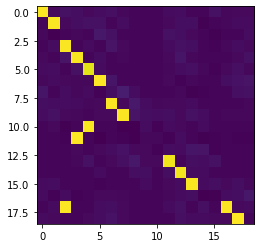

In [85]:
weight=[[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
weight=torch.Tensor(weight).reshape((1,1,4,4)).float()
print(weight,weight.shape)

file=Image.open('./imgs/img1.png')
w=file.width
h=file.height

inputs=torch.Tensor(np.array(file)).reshape((1,1,h,w))
print(inputs,inputs.shape)

# 提取有对角线特征的部分
outputs=F.conv2d(inputs,weight,stride=2)
print(outputs,outputs.shape)
outputs=outputs.reshape((1,19,19))
# 展示图片
out_f=transforms.ToPILImage()(outputs)
plt.imshow(out_f)

那么可见：**卷积根据卷积核(特征)通过压缩图片的方式，得到多个维度的有卷积核特征的特征图**。

反卷积呢？我们也可以来一下：

tensor([[[0.9961, 1.0000, 0.9922,  ..., 1.0000, 0.9961, 0.9961],
         [0.0000, 0.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.9922, 1.0000],
         ...,
         [1.0000, 1.0000, 0.0039,  ..., 0.9922, 1.0000, 1.0000],
         [0.9882, 0.0039, 0.0039,  ..., 0.0118, 1.0000, 0.9961],
         [0.0078, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0039]]]) torch.Size([1, 40, 40])
tensor([[[[0.9961, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.9961, 0.0000,  ..., 0.9961, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.9961,  ..., 0.0000, 0.9961, 0.0000],
          ...,
          [0.0000, 0.0078, 0.0000,  ..., 1.0039, 0.0000, 0.9961],
          [0.0000, 0.0000, 0.0078,  ..., 0.0000, 0.0039, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0039]]]]) torch.Size([1, 1, 82, 82])


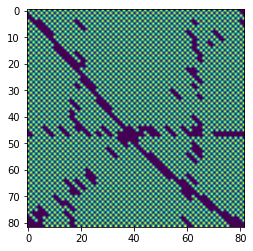

In [93]:
inputs_tensor=transforms.ToTensor()(Image.open('./imgs/img1.png'))
print(inputs_tensor,inputs_tensor.shape)
inputs_tensor=inputs_tensor.reshape((1,1,40,40))
# 接着使用上面的权重矩阵
outputs_tensor=F.conv_transpose2d(inputs_tensor,weight,stride=2) # output=2*(40-1)+4-2*0=78+4=43
print(outputs_tensor,outputs_tensor.shape)
outputs_tensor=outputs_tensor.reshape((1,82,82))

outputs_file=transforms.ToPILImage()(outputs_tensor)
plt.imshow(outputs_file)

可看出反卷积也是完成了一个“**特征模拟还原**”的过程，那么可以说：**反卷积是根据卷积核(的特征)通过增加图片尺寸的方式，提取多个维度特征图片的语义信息融合得到有卷积核特征的图片**。

### 3.成本函数——Dice Loss

语义信息的输入和图像分类一样，但是输出的是一个图片，但是其本质还是分类问题。换句话说，我们需要对像素的分类进行一个损失计算。

语义分割在损失函数方面，没有使用普通回归任务的MSE，而是使用了一种叫做Dice的**集合相似度度量**函数。

该函数最大的特征就是基于矩阵运算得到输出的像素分类图和标签之间的loss，基本思想就是计算prediction与label的交集，再计算两者的并集，相除并乘以2得到**Dice系数**

$$
\lambda_{dice]}=\frac{2|pred\cap label|}{|pred|+|label|}
$$

这就类似于交并比，这个Dice系数在某种意义上可以看成是一种相似度，用1减去这个值就可以得到损失。那么如何计算DiceLoss呢？

In [8]:
prediction=torch.arange(1,26).reshape((5,5))
target=torch.FloatTensor([[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0],[1,0,0,0,0]])
output=prediction*target
print(output)

tensor([[ 1.,  0.,  0.,  0.,  0.],
        [ 6.,  0.,  0.,  0.,  0.],
        [11.,  0.,  0.,  0.,  0.],
        [16.,  0.,  0.,  0.,  0.],
        [21.,  0.,  0.,  0.,  0.]])


我们这里用一个二分类举例子，对于target就只有前景1和背景0，那么我们要做的就是计算出与前景1有重叠的部分，很想然就是最左边的第一列数据，运用矩阵点乘——注意不是矩阵乘法，得到结果。

In [11]:
inter=output.sum()
div=prediction.sum()+target.sum()
diceloss=1-2*inter/div
print(diceloss)

tensor(0.6667)


然后讲矩阵元素全部加起来就可以了。

至于|prediction|和|label|的计算，可以使用平方和，也可以直接相加。

其实不难发现，这里的面积实质就是数字矩阵，并且还运用了近似的方法得到”交并比“。

但是，DiceLoss函数的缺点也很明显——不是一个“确定的函数”，他不跟MSE这种平方和公式一样，DiceLoss是一种集合相似度函数，对反向传播中的求导有不利影响，容易是的训练不稳定。